<a href="https://colab.research.google.com/github/arofenitra/Scientific-Computing/blob/main/image_processing/image_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definition, methods
- Goal : To reduce the cost of storage of a digital image.

- Lossy and lossless image compression
Lossless compression when no information is lost during the compression-decompression process, The perfect recovery of the original image is achieved. We can use in text compression and all methods that requires full recovery of the data. Otherwise it is lossy compression, we can use it for image compression or video compression where the full recovery of the data is not needed
- Methods : Lossy compression, using Transform coding (DCT compression and Wavelet based image compression)


<img src="https://github.com/arofenitra/Scientific-Computing/blob/main/image_processing/compression_images/image_compression_method.jpeg?raw=1">  

Wavelet based compression:   
<img src="https://github.com/arofenitra/Scientific-Computing/blob/main/image_processing/compression_images/block_diagram_of_the_jpeg_2000_encoder_algorithm_bdataflow.jpeg?raw=1">  

DCT based compression:  
<img src="https://github.com/arofenitra/Scientific-Computing/blob/main/image_processing/compression_images/block_diagram_of_sequential_jpeg_encoder_and_decoder.jpeg?raw=1">  


### JPEG Image compression
We will follow the algorithm :


- **JPEG Compression**:

1. **Color Space Conversion**:  
The input image is converted from RGB (Red, Green, Blue) color space to YCbCr (Luminance and Chrominance) color space.
Chroma Subsampling: The chrominance components (Cb and Cr) are subsampled by a factor of 2 in both horizontal and vertical directions, resulting in a reduced-resolution image.
2. **Discrete Cosine Transform (DCT)**:  
 The luminance (Y) and chrominance (Cb and Cr) components are divided into 8x8 blocks and transformed using the DCT, which converts the spatial domain data into frequency domain data.
3. **Quantization**:  
The DCT coefficients are quantized to reduce the precision of the coefficients and discard some of the high-frequency components.
4. **Zigzag Reordering**:   
The quantized coefficients are reordered in a zigzag pattern to group the low-frequency coefficients together.
5. **Run-Length Encoding (RLE)**:  
The reordered coefficients are encoded using RLE, which replaces sequences of zeros with a single value.
6. **Huffman Coding**:  
The RLE-encoded coefficients are encoded using Huffman coding, which assigns variable-length codes to the coefficients based on their frequency of occurrence.
6. **Bitstream Formation**:  
The Huffman-coded coefficients are formed into a bitstream, which is the compressed JPEG image.  

- **JPEG Decompression**:

7. **Bitstream Extraction**:  
The compressed JPEG image is extracted from the bitstream.
8. **Huffman Decoding**:  
The Huffman-coded coefficients are decoded using Huffman decoding, which reverses the variable-length coding.
9. **Run-Length Decoding**:  
The RLE-encoded coefficients are decoded using RLE decoding, which replaces the single values with sequences of zeros.
10. **Zigzag Reordering**:  
The reordered coefficients are reordered in the original zigzag pattern.
11. **Inverse Quantization**:  
The quantized coefficients are inverse quantized to restore the original precision.
12. **Inverse Discrete Cosine Transform (IDCT)**:  
The IDCT is applied to the inverse quantized coefficients to transform the frequency domain data back into spatial domain data.
13. **Chroma Upsampling**:  
The chrominance components (Cb and Cr) are upsampled to their original resolution.
14. **Color Space Conversion**:  
The YCbCr image is converted back to RGB color space.
15. **Image Reconstruction**: The decompressed image is reconstructed from the RGB components.

In [ ]:
!pip install huffman

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import requests
from io import BytesIO


# Function to download an image from a URL
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

# Load an example image from a URL
image_url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
image = download_image(image_url)
image = image.convert('RGB')
image_array = np.array(image)
# Step 1: Color Space Conversion (RGB to YCbCr)
def rgb_to_ycbcr(image):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    y = 0.299 * r + 0.587 * g + 0.114 * b
    cb = -0.1687 * r - 0.3313 * g + 0.5 * b + 128
    cr = 0.5 * r - 0.4187 * g - 0.0813 * b + 128
    return np.stack((y, cb, cr), axis=2)

ycbcr_image = rgb_to_ycbcr(image_array)

# Step 2: Chroma Subsampling
def chroma_subsampling(ycbcr_image):
    y, cb, cr = ycbcr_image[:, :, 0], ycbcr_image[:, :, 1], ycbcr_image[:, :, 2]
    cb_sub = cb[::2, ::2]
    cr_sub = cr[::2, ::2]
    return y, cb_sub, cr_sub

y, cb_sub, cr_sub = chroma_subsampling(ycbcr_image)

# Step 3: Discrete Cosine Transform (DCT)
def apply_dct(component):
    h, w = component.shape
    dct_blocks = np.zeros((h // 8, w // 8, 8, 8))
    for i in range(h // 8):
        for j in range(w // 8):
            block = component[i*8:(i+1)*8, j*8:(j+1)*8]
            dct_blocks[i, j] = dct(dct(block.T, norm='ortho').T, norm='ortho')
    return dct_blocks

y_dct = apply_dct(y)
cb_dct = apply_dct(cb_sub)
cr_dct = apply_dct(cr_sub)

# Step 4: Quantization
def quantize(dct_blocks, quantization_matrix):
    return np.round(dct_blocks / quantization_matrix)

quantization_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

y_quantized = quantize(y_dct, quantization_matrix)
cb_quantized = quantize(cb_dct, quantization_matrix)
cr_quantized = quantize(cr_dct, quantization_matrix)

# Step 5: Zigzag Reordering
def zigzag(block):
    return block.flatten()[np.argsort([sum([(x//8)*8 + (y%8) for x, y in zip(range(8), range(8))])])]

y_zigzag = np.array([zigzag(block) for block in y_quantized.reshape(-1, 8, 8)])
cb_zigzag = np.array([zigzag(block) for block in cb_quantized])
cr_zigzag = np.array([zigzag(block) for block in cr_quantized])
# Step 6: Run-Length Encoding (RLE)
def run_length_encode(zigzag_coefficients):
    encoded = []
    count = 0
    for coeff in zigzag_coefficients:
        if coeff == 0:
            count += 1
        else:
            if count > 0:
                encoded.append((0, count))
                count = 0
            encoded.append((coeff, 0))
    if count > 0:
        encoded.append((0, count))
    return encoded

y_rle = run_length_encode(y_zigzag.flatten())
cb_rle = run_length_encode(cb_zigzag.flatten())
cr_rle = run_length_encode(cr_zigzag.flatten())

# Step 7: Huffman Coding
class Node:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

def calculate_frequency(message):
    frequency = {}
    for symbol in message:
        if symbol not in frequency:
            frequency[symbol] = 0
        frequency[symbol] += 1
    return frequency

def build_huffman_tree(frequency):
    heap = [Node(char, freq) for char, freq in frequency.items()]
    while len(heap) > 1:
        heap.sort(key=lambda x: x.freq)
        lo = heap.pop(0)
        hi = heap.pop(0)
        for pair in lo.left, lo.right, hi.left, hi.right:
            if pair:
                pair.freq += 1
        merged = Node(None, lo.freq + hi.freq)
        merged.left = lo
        merged.right = hi
        heap.append(merged)
    return heap[0]

def build_codes_helper(root, current_code, codes):
    if root == None:
        return
    if root.char != None:
        codes[root.char] = current_code
    build_codes_helper(root.left, current_code + "0", codes)
    build_codes_helper(root.right, current_code + "1", codes)

def build_codes(root):
    codes = {}
    build_codes_helper(root, "", codes)
    return codes

def huffman_encoding(message):
    frequency = calculate_frequency(message)
    huffman_tree = build_huffman_tree(frequency)
    huffman_codes = build_codes(huffman_tree)
    encoded_message = ""
    for char in message:
        encoded_message += huffman_codes[char]
    return encoded_message, huffman_tree

def huffman_decoding(encoded_message, huffman_tree):
    decoded_message = ""
    current_node = huffman_tree
    for bit in encoded_message:
        if bit == "0":
            current_node = current_node.left
        else:
            current_node = current_node.right
        if current_node.char != None:
            decoded_message += current_node.char
            current_node = huffman_tree
    return decoded_message


y_huffman_encoded, y_huffman_tree = huffman_encoding(str(y_rle))
cb_huffman_encoded, cb_huffman_tree = huffman_encoding(str(cb_rle))
cr_huffman_encoded, cr_huffman_tree = huffman_encoding(str(cr_rle))

# JPEG Decompression

# Step 1: Huffman Decoding
import ast
y_huffman_decoded = ast.literal_eval(huffman_decoding(y_huffman_encoded, y_huffman_tree))
cb_huffman_decoded = ast.literal_eval(huffman_decoding(cb_huffman_encoded, cb_huffman_tree))
cr_huffman_decoded = ast.literal_eval(huffman_decoding(cr_huffman_encoded, cr_huffman_tree))

# Step 2: Run-Length Decoding
def run_length_decode(rle_encoded):
    decoded = []
    for value, count in rle_encoded:
        if value == 0:
            decoded.extend([0] * count)
        else:
            decoded.append(value)
    return np.array(decoded)

y_rle_decoded = run_length_decode(y_huffman_decoded)
cb_rle_decoded = run_length_decode(cb_huffman_decoded)
cr_rle_decoded = run_length_decode(cr_huffman_decoded)



(2, 0)


In [10]:
print(len(y_rle_decoded))
y_rle_decoded=np.array(y_rle_decoded)
cb_rle_decoded=np.array(y_rle_decoded)
cr_rle_decoded=np.array(y_rle_decoded.reshape(-1, 8, 8))
print(cr_rle_decoded)

4096
[[[ 80.  79.  78. ...  85.  84.  66.]
  [ 47.  52.  53. ...  57.  61.  63.]
  [ 65.  66.  65. ...  67.  66.  66.]
  ...
  [ 60.  74.  79. ...  77.  76.  77.]
  [ 78.  78.  89. ...  53.  59.  60.]
  [ 61.  61.  62. ...  62.  60.  68.]]

 [[ 78.  78.  78. ...  85.  81.  64.]
  [ 46.  50.  53. ...  57.  61.  63.]
  [ 64.  65.  65. ...  66.  66.  66.]
  ...
  [ 55.  69.  78. ...  79.  78.  77.]
  [ 77.  76.  78. ...  69.  56.  60.]
  [ 61.  60.  61. ...  64.  49.  25.]]

 [[ 78.  79.  78. ...  82.  79.  65.]
  [ 46.  50.  53. ...  56.  60.  62.]
  [ 64.  65.  65. ...  66.  66.  66.]
  ...
  [ 54.  63.  76. ...  81.  79.  78.]
  [ 77.  76.  75. ...  99.  56.  58.]
  [ 60.  61.  62. ...  46.  24.  24.]]

 ...

 [[ 34.  53.  85. ...  87.  91.  78.]
  [ 34.  24.  27. ...  34.  32.  45.]
  [ 32.  30.  37. ...  22.  22.  24.]
  ...
  [ 78.  83.  89. ... 105. 107.  57.]
  [ 49.  52.  51. ...  68.  42.  39.]
  [ 40.  51.  39. ...  51.  34.  30.]]

 [[ 28.  41.  90. ...  87.  91.  72.]
  [ 29.

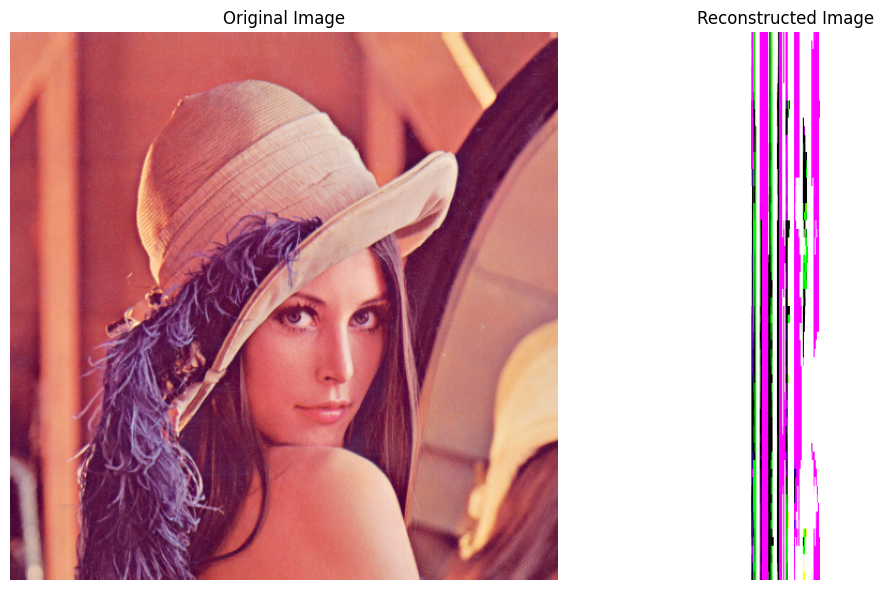

ValueError: Input images must have the same dimensions.

Compression Ratio: 8.00


In [13]:

# Step 3: Zigzag Reordering
# Step 3: Zigzag Reordering
def inverse_zigzag(reordered_coefficients):
    inverse_reorder = np.zeros(reordered_coefficients.shape)
    for i in range(reordered_coefficients.shape[0]):
        block = reordered_coefficients[i]
        inverse_reorder[i] = np.sort(block)
    return inverse_reorder

y_inverse_reordered = inverse_zigzag(y_rle_decoded.reshape(-1, 8, 8))
cb_inverse_reordered = inverse_zigzag(cb_rle_decoded.reshape(-1, 8, 8))
cr_inverse_reordered = inverse_zigzag(cr_rle_decoded.reshape(-1, 8,8))


y_inverse_reordered = inverse_zigzag(y_rle_decoded.reshape(-1, 8, 8))
cb_inverse_reordered = inverse_zigzag(cb_rle_decoded.reshape(-1, 8, 8))
cr_inverse_reordered = inverse_zigzag(cr_rle_decoded.reshape(-1, 8,8))

                      # Step 4: Inverse Quantization
def inverse_quantize(quantized_dct_blocks, quantization_matrix):
    return quantized_dct_blocks * quantization_matrix

y_inverse_quantized = inverse_quantize(y_inverse_reordered, quantization_matrix)
cb_inverse_quantized = inverse_quantize(cb_inverse_reordered, quantization_matrix)
cr_inverse_quantized = inverse_quantize(cr_inverse_reordered, quantization_matrix)

# Step 5: Inverse DCT
def inverse_dct(dct_blocks):
    h, w, _ = dct_blocks.shape
    idct_blocks = np.zeros((h * 8, w * 8))
    for i in range(h):
        for j in range(w):
            block = idct(idct(dct_blocks[i, j].T, norm='ortho').T, norm='ortho')
            idct_blocks[i*8:(i+1)*8, j*8:(j+1)*8] = block
    return idct_blocks

y_idct = inverse_dct(y_inverse_quantized)
cb_idct = inverse_dct(cb_inverse_quantized)
cr_idct = inverse_dct(cr_inverse_quantized)

# Step 6: Chroma Upsampling# Step 6: Chroma Upsampling
cb_upsampled = np.repeat(np.repeat(cb_idct, 2, axis=0), 2, axis=1)
cr_upsampled = np.repeat(np.repeat(cr_idct, 2, axis=0), 2, axis=1)

# Trim the upsampled chroma components to match the size of the luminance component
cb_upsampled = cb_upsampled[:y_idct.shape[0], :y_idct.shape[1]]
cr_upsampled = cr_upsampled[:y_idct.shape[0], :y_idct.shape[1]]

# Combine the Y, Cb, and Cr components
ycbcr_reconstructed = np.stack((y_idct, cb_upsampled, cr_upsampled), axis=2)


# Step 7: Color Space Conversion (YCbCr to RGB)
def ycbcr_to_rgb(ycbcr_image):
    y, cb, cr = ycbcr_image[:, :, 0], ycbcr_image[:, :, 1], ycbcr_image[:, :, 2]
    r = y + 1.402 * (cr - 128)
    g = y - 0.3441 * (cb - 128) - 0.7141 * (cr - 128)
    b = y + 1.772 * (cb - 128)
    return np.stack((r, g, b), axis=2)

# Combine the Y, Cb, and Cr components
ycbcr_reconstructed = np.stack((y_idct, cb_upsampled, cr_upsampled), axis=2)

# Convert YCbCr back to RGB
rgb_reconstructed = ycbcr_to_rgb(ycbcr_reconstructed)

# Clip the values to the valid range [0, 255]
rgb_reconstructed = np.clip(rgb_reconstructed, 0, 255).astype(np.uint8)

# Display the original and reconstructed images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rgb_reconstructed)
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Evaluate Compression Effectiveness
def evaluate_compression(original_image, compressed_image):
    # File size comparison
    original_size = original_image.size * original_image.itemsize
    compressed_size = compressed_image.size * compressed_image.itemsize
    compression_ratio = original_size / compressed_size
    print(f"Compression Ratio: {compression_ratio:.2f}")

    # PSNR
    psnr_value = psnr(original_image, compressed_image)
    print(f"PSNR: {psnr_value:.2f} dB")

    # SSIM
    ssim_value, _ = ssim(original_image, compressed_image, full=True, multichannel=True)
    print(f"SSIM: {ssim_value:.2f}")

evaluate_compression(image_array, rgb_reconstructed)





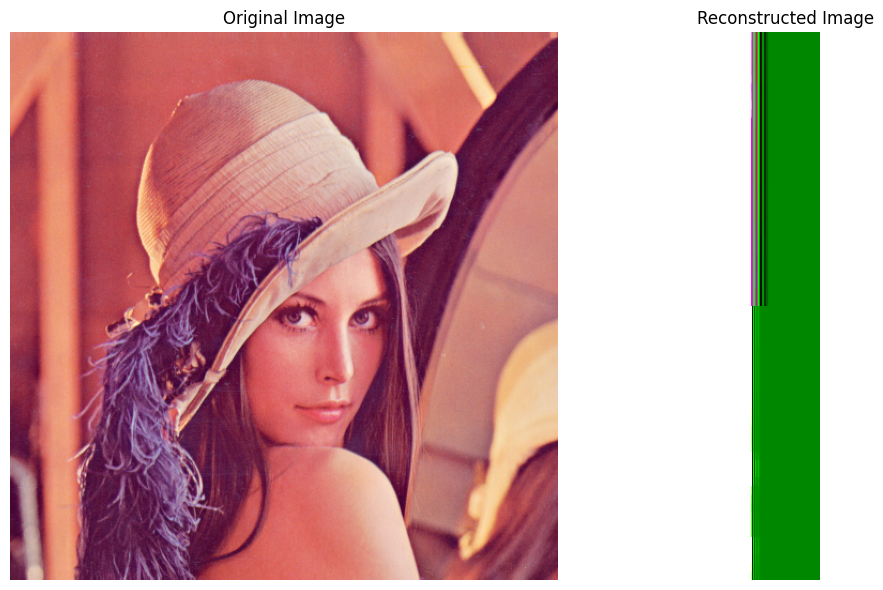

Compression Ratio: 8.00


ValueError: Input images must have the same dimensions.

In [19]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import requests
from io import BytesIO

# Function to download an image from a URL
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

# Load an example image from a URL
image_url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
image = download_image(image_url)
image = image.convert('RGB')
image_array = np.array(image)

# Step 1: Color Space Conversion (RGB to YCbCr)
def rgb_to_ycbcr(image):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    y = 0.299 * r + 0.587 * g + 0.114 * b
    cb = -0.1687 * r - 0.3313 * g + 0.5 * b + 128
    cr = 0.5 * r - 0.4187 * g - 0.0813 * b + 128
    return np.stack((y, cb, cr), axis=2)

ycbcr_image = rgb_to_ycbcr(image_array)

# Step 2: Chroma Subsampling
def chroma_subsampling(ycbcr_image):
    y, cb, cr = ycbcr_image[:, :, 0], ycbcr_image[:, :, 1], ycbcr_image[:, :, 2]
    cb_sub = cb[::2, ::2]
    cr_sub = cr[::2, ::2]
    return y, cb_sub, cr_sub

y, cb_sub, cr_sub = chroma_subsampling(ycbcr_image)

# Step 3: Discrete Cosine Transform (DCT)
def apply_dct(component):
    h, w = component.shape
    dct_blocks = np.zeros((h // 8, w // 8, 8, 8))
    for i in range(h // 8):
        for j in range(w // 8):
            block = component[i*8:(i+1)*8, j*8:(j+1)*8]
            dct_blocks[i, j] = dct(dct(block.T, norm='ortho').T, norm='ortho')
    return dct_blocks

y_dct = apply_dct(y)
cb_dct = apply_dct(cb_sub)
cr_dct = apply_dct(cr_sub)

# Step 4: Quantization
def quantize(dct_blocks, quantization_matrix):
    return np.round(dct_blocks / quantization_matrix)

quantization_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

y_quantized = quantize(y_dct, quantization_matrix)
cb_quantized = quantize(cb_dct, quantization_matrix)
cr_quantized = quantize(cr_dct, quantization_matrix)

# Step 5: Zigzag Reordering
def zigzag(block):
    return block.flatten()[np.argsort([sum([(x//8)*8 + (y%8) for x, y in zip(range(8), range(8))])])]

y_zigzag = np.array([zigzag(block) for block in y_quantized.reshape(-1, 8, 8)])
cb_zigzag = np.array([zigzag(block) for block in cb_quantized.reshape(-1, 8, 8)])
cr_zigzag = np.array([zigzag(block) for block in cr_quantized.reshape(-1, 8, 8)])

# Step 6: Run-Length Encoding (RLE)
def run_length_encode(zigzag_coefficients):
    encoded = []
    count = 0
    for coeff in zigzag_coefficients:
        if coeff == 0:
            count += 1
        else:
            if count > 0:
                encoded.append((0, count))
                count = 0
            encoded.append((coeff, 0))
    if count > 0:
        encoded.append((0, count))
    return encoded

y_rle = run_length_encode(y_zigzag.flatten())
cb_rle = run_length_encode(cb_zigzag.flatten())
cr_rle = run_length_encode(cr_zigzag.flatten())

# Step 7: Huffman Coding
class Node:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

def calculate_frequency(message):
    frequency = {}
    for symbol in message:
        if symbol not in frequency:
            frequency[symbol] = 0
        frequency[symbol] += 1
    return frequency

def build_huffman_tree(frequency):
    heap = [Node(char, freq) for char, freq in frequency.items()]
    while len(heap) > 1:
        heap.sort(key=lambda x: x.freq)
        lo = heap.pop(0)
        hi = heap.pop(0)
        merged = Node(None, lo.freq + hi.freq)
        merged.left = lo
        merged.right = hi
        heap.append(merged)
    return heap[0]

def build_codes_helper(root, current_code, codes):
    if root == None:
        return
    if root.char != None:
        codes[root.char] = current_code
    build_codes_helper(root.left, current_code + "0", codes)
    build_codes_helper(root.right, current_code + "1", codes)

def build_codes(root):
    codes = {}
    build_codes_helper(root, "", codes)
    return codes

def huffman_encoding(message):
    frequency = calculate_frequency(message)
    huffman_tree = build_huffman_tree(frequency)
    huffman_codes = build_codes(huffman_tree)
    encoded_message = ""
    for char in message:
        encoded_message += huffman_codes[char]
    return encoded_message, huffman_tree

def huffman_decoding(encoded_message, huffman_tree):
    decoded_message = ""
    current_node = huffman_tree
    for bit in encoded_message:
        if bit == "0":
            current_node = current_node.left
        else:
            current_node = current_node.right
        if current_node.char != None:
            decoded_message += current_node.char
            current_node = huffman_tree
    return decoded_message

y_huffman_encoded, y_huffman_tree = huffman_encoding(str(y_rle))
cb_huffman_encoded, cb_huffman_tree = huffman_encoding(str(cb_rle))
cr_huffman_encoded, cr_huffman_tree = huffman_encoding(str(cr_rle))

# JPEG Decompression

# Step 1: Huffman Decoding
import ast
y_huffman_decoded = ast.literal_eval(huffman_decoding(y_huffman_encoded, y_huffman_tree))
cb_huffman_decoded = ast.literal_eval(huffman_decoding(cb_huffman_encoded, cb_huffman_tree))
cr_huffman_decoded = ast.literal_eval(huffman_decoding(cr_huffman_encoded, cr_huffman_tree))

# Step 2: Run-Length Decoding
def run_length_decode(rle_encoded):
    decoded = []
    for value, count in rle_encoded:
        if value == 0:
            decoded.extend([0] * count)
        else:
            decoded.append(value)
    return np.array(decoded)

y_rle_decoded = run_length_decode(y_huffman_decoded)
cb_rle_decoded = run_length_decode(cb_huffman_decoded)
cr_rle_decoded = run_length_decode(cr_huffman_decoded)

# Step 3: Inverse Zigzag Reordering
def inverse_zigzag(reordered_coefficients):
    inverse_reorder = np.zeros((64,))
    indices = np.argsort([sum([(x//8)*8 + (y%8) for x, y in zip(range(8), range(8))])])
    for i, idx in enumerate(indices):
        inverse_reorder[idx] = reordered_coefficients[i]
    return inverse_reorder.reshape(8, 8)

y_inverse_reordered = np.array([inverse_zigzag(block) for block in y_rle_decoded.reshape(-1, 64)])
cb_inverse_reordered = np.array([inverse_zigzag(block) for block in cb_rle_decoded.reshape(-1, 64)])
cr_inverse_reordered = np.array([inverse_zigzag(block) for block in cr_rle_decoded.reshape(-1, 64)])

# Step 4: Inverse Quantization
def inverse_quantize(quantized_dct_blocks, quantization_matrix):
    return quantized_dct_blocks * quantization_matrix

y_inverse_quantized = inverse_quantize(y_inverse_reordered, quantization_matrix)
cb_inverse_quantized = inverse_quantize(cb_inverse_reordered, quantization_matrix)
cr_inverse_quantized = inverse_quantize(cr_inverse_reordered, quantization_matrix)

# Step 5: Inverse DCT
def inverse_dct(dct_blocks):
    h, w,  _ = dct_blocks.shape
    idct_blocks = np.zeros((h * 8, w * 8))
    for i in range(h):
        for j in range(w):
            block = idct(idct(dct_blocks[i, j].T, norm='ortho').T, norm='ortho')
            idct_blocks[i*8:(i+1)*8, j*8:(j+1)*8] = block
    return idct_blocks

y_idct = inverse_dct(y_inverse_quantized)
cb_idct = inverse_dct(cb_inverse_quantized)
cr_idct = inverse_dct(cr_inverse_quantized)

# Step 6: Chroma Upsampling
def pad_and_upsample(component, target_shape):
    padded_component = np.pad(component, ((0, target_shape[0] - component.shape[0]), (0, target_shape[1] - component.shape[1])), 'constant')
    upsampled_component = np.repeat(np.repeat(padded_component, 2, axis=0), 2, axis=1)
    return upsampled_component[:target_shape[0], :target_shape[1]]

cb_upsampled = pad_and_upsample(cb_idct, y_idct.shape)
cr_upsampled = pad_and_upsample(cr_idct, y_idct.shape)

# Combine the Y, Cb, and Cr components
ycbcr_reconstructed = np.stack((y_idct, cb_upsampled, cr_upsampled), axis=2)

# Step 7: Color Space Conversion (YCbCr to RGB)
def ycbcr_to_rgb(ycbcr_image):
    y, cb, cr = ycbcr_image[:, :, 0], ycbcr_image[:, :, 1], ycbcr_image[:, :, 2]
    r = y + 1.402 * (cr - 128)
    g = y - 0.3441 * (cb - 128) - 0.7141 * (cr - 128)
    b = y + 1.772 * (cb - 128)
    return np.stack((r, g, b), axis=2)

# Convert YCbCr back to RGB
rgb_reconstructed = ycbcr_to_rgb(ycbcr_reconstructed)

# Clip the values to the valid range [0, 255]
rgb_reconstructed = np.clip(rgb_reconstructed, 0, 255).astype(np.uint8)

# Display the original and reconstructed images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rgb_reconstructed)
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Evaluate Compression Effectiveness
def evaluate_compression(original_image, compressed_image):
    # File size comparison
    original_size = original_image.size * original_image.itemsize
    compressed_size = compressed_image.size * compressed_image.itemsize
    compression_ratio = original_size / compressed_size
    print(f"Compression Ratio: {compression_ratio:.2f}")

    # PSNR
    psnr_value = psnr(original_image, compressed_image)
    print(f"PSNR: {psnr_value:.2f} dB")

    # SSIM
    ssim_value, _ = ssim(original_image, compressed_image, full=True, multichannel=True)
    print(f"SSIM: {ssim_value:.2f}")

evaluate_compression(image_array, rgb_reconstructed)


TypeError: 'Image' object is not subscriptable

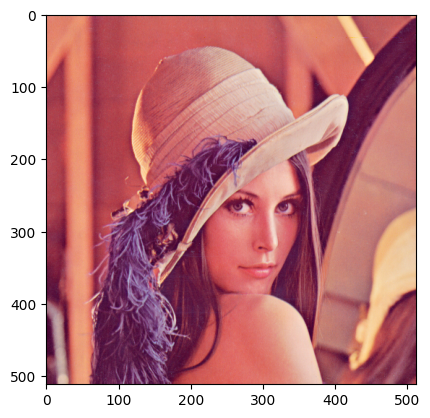

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import requests
from io import BytesIO

# Function to download an image from a URL
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

# Load an example image from a URL
image_url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
image = download_image(image_url)
image = image.convert('RGB')
image_array = np.array(image)

# Step 1: Color Space Conversion (RGB to YCbCr)
def rgb_to_ycbcr(image):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    y = 0.299 * r + 0.587 * g + 0.114 * b
    cb = -0.1687 * r - 0.3313 * g + 0.5 * b + 128
    cr = 0.5 * r - 0.4187 * g - 0.0813 * b + 128
    return np.stack((y, cb, cr), axis=2)
def ycbcrto_rgb(image):
    y,cb,cr=image[:, :, 0], image[:, :, 1], image[:, :, 2]
    cb=np.zeros_like(cb)
    cr=np.zeros_like(cr)
    r,g,b=np.linalg.inv(np.array([[0.299,0.587,0.114],[0.1687,0.3313,-0.5],[0.5,-0.4187,-0.0813]]))@np.array([[0],[128],[-128]])
    return np.stack((a*y,0,0),axis=2)
plt.imshow(image_array)
ycbcr_image = rgb_to_ycbcr(image_array)
plt.imshow(ycbcrto_rgb(image))

In [8]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.1 MB/s eta 0:00:00


In [37]:
import numpy as np
from PIL import Image
import pywt
import matplotlib.pyplot as plt

# Function to compress image using Wavelets
def compress_image(image_path, threshold):
    # Load the image
    image = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale

    # Apply Wavelet transform
    coeffs = pywt.wavedec2(image, 'haar', level=2)

    # Get the shapes of the coefficients
    coeff_shapes = [coeff.shape for coeff in coeffs]

    # Flatten the coefficients
    flat_coeffs = np.concatenate([coeff.flatten() for coeff in coeffs])

    # Zero out the coefficients that are below a certain threshold
    flat_coeffs = np.where(np.abs(flat_coeffs) < threshold, 0, flat_coeffs)

    # Reconstruct the coefficients
    start = 0
    compressed_coeffs = []
    for shape in coeff_shapes:
        if len(shape) == 2:
            size = shape[0] * shape[1]
            compressed_coeffs.append(flat_coeffs[start:start + size].reshape(shape))
            start += size
        else:
            compressed_coeffs.append(flat_coeffs[start:start + shape])
            start += shape

    # Reconstruct the image
    compressed_image = pywt.wavethresh(compressed_coeffs, 'hard')

    # Convert the compressed image back to a numpy array
    compressed_image = np.array(pywt.idwt2(compressed_image, 'haar'))

    # Clip the pixel values to the range [0, 255]
    compressed_image = np.clip(compressed_image, 0, 255)

    # Convert the compressed image to uint8
    compressed_image = compressed_image.astype(np.uint8)

    return compressed_image

# Function to compress image using DCT
def dct_compress(image_path, compression_level):
    # Load the image
    image = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale

    # Apply DCT to each 8x8 block of the image
    dct_blocks = []
    for i in range(0, image.shape[0], 8):
        for j in range(0, image.shape[1], 8):
            block = image[i:i+8, j:j+8]
            dct_block = np.round(np.cos(np.arange(8) * np.pi / 16) * np.dot(np.cos(np.arange(8) * np.pi / 16), block))
            dct_blocks.append(dct_block)

    # Zero out the coefficients that are below a certain threshold
    threshold = np.sqrt(2 * np.log(image.size))
    for i in range(len(dct_blocks)):
        dct_blocks[i] = np.where(np.abs(dct_blocks[i]) < threshold, 0, dct_blocks[i])

    # Reconstruct the image
    compressed_image = np.zeros(image.shape)
    index = 0
    for i in range(0, image.shape[0], 8):
        for j in range(0, image.shape[1], 8):
            compressed_image[i:i+8, j:j+8] = np.round(np.dot(np.cos(np.arange(8) * np.pi / 16), np.dot(np.cos(np.arange(8) * np.pi / 16), dct_blocks[index])))
            index += 1

    # Clip the pixel values to the range [0, 255]
    compressed_image = np.clip(compressed_image, 0, 255)

    # Convert the compressed image to uint8
    compressed_image = compressed_image.astype(np.uint8)

    return compressed_image

# Test the functions
image_path = 'lena_grey.jpeg'
threshold = 20

wavelet_compressed_image = compress_image(image_path, threshold)
dct_compressed_image = dct_compress(image_path, 2)

# Display the original and compressed images
original_image = Image.open(image_path)
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(wavelet_compressed_image, cmap='gray')
plt.title('Wavelet Compressed Image')

plt.subplot(1, 3, 3)
plt.imshow(dct_compressed_image, cmap='gray')
plt.title('DCT Compressed Image')

plt.show()


AttributeError: 'tuple' object has no attribute 'shape'

## Wavelet based compression

### Decomposition matrix

1. For the case of Daubechie 4 wavelets, :  

We have the lowpass filter

$$h_0 = \frac{1 + \sqrt{3}}{4\sqrt{2}}
h_1 = \frac{3 + \sqrt{3}}{4\sqrt{2}}
h_2 = \frac{3- \sqrt{3}}{4\sqrt{2}}
h_3 = \frac{1 - \sqrt{3}}{4\sqrt{2}}$$

Also, we have, the highpass filter

$$g[N-1-n]=(-1)^nh[n]\; ∀n$$

Where $N$ is the filter length(N=2 for haar and N=4 for daubechies 4.

As the daubechies 4-tap wavelets are orthogonal, the following matrix is equal to its inverse. $$W=W^{-1}$$
where


$$W=\left[\begin{matrix}h_0&h_1&h_2&h_3 \\h_3 &-h_2&h_1&-h_0&&&&&& \\ &&h_0&h_1&h_2&h_3 \\&&h_3 &-h_2&h_1&-h_0 \\ \\ \\\\h_2 &h_3&&&&&&&h_0&h_1\\h_1 &-h_0 &&&&&&&h_3&-h_2\end{matrix}\right]$$
For the case of Haar wavelet, we get the lowpass filter: $$h_0=\frac{1}{\sqrt{2}}=h_1=g_1=-g_0$$
$$W=W^{-1}=\left[\begin{matrix}h_0&h_1&&&& \\h_1&-h_0&&&&\\&h_0&h_1&&& \\&h_1&-h_0&&&\\ \\ \\ \\ h_1 &&&&&h_0\\-h_0&&&&&h_1\\\end{matrix}  \right]$$



In [ ]:
import pywt
import pywt.data
from PIL import Image
import numpy as np

def load_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    return np.array(image)
def wavelet_transform(image):
    coeffs = pywt.wavedec2(image, 'haar', level=1)
    return coeffs
def quantize_coefficients(coeffs, threshold):
    cA, (cH, cV, cD) = coeffs
    cH = np.where(np.abs(cH) < threshold, 0, cH)
    cV = np.where(np.abs(cV) < threshold, 0, cV)
    cD = np.where(np.abs(cD) < threshold, 0, cD)
    return cA, (cH, cV, cD)
def inverse_wavelet_transform(coeffs):
    return pywt.waverec2(coeffs, 'haar')
def save_image(image, output_path):
    Image.fromarray(image.astype(np.uint8)).save(output_path)
def main(image_path, output_path, threshold):
    image = load_image(image_path)
    coeffs = wavelet_transform(image)
    quantized_coeffs = quantize_coefficients(coeffs, threshold)
    reconstructed_image = inverse_wavelet_transform(quantized_coeffs)
    save_image(reconstructed_image, output_path)

if __name__ == "__main__":
    main('aaaaaa.jpg', 'compressed_image1.jpg', threshold=10)
    main('Cool-Black-And-White-Wallpapers-Resolution-1920x1080-Desktop-Backgrounds-124.jpg','compressed_image2.jpg', threshold=20)



In [48]:
!sudo apt install python3-zigzag


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python3-zigzag


In [43]:
import cv2
import numpy as np
import math
from zigzag import zigzag, inverse_zigzag

# Quantization Matrix
QUANTIZATION_MAT = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Block size
block_size = 8

def dct_quantize(image):
    h, w = image.shape
    h = np.float32(h)
    w = np.float32(w)

    nbh = math.ceil(h / block_size)
    nbw = math.ceil(w / block_size)

    H = block_size * nbh
    W = block_size * nbw

    padded_img = np.zeros((H, W))
    padded_img[0:h, 0:w] = image[0:h, 0:w]

    for i in range(nbh):
        row_ind_1 = i * block_size
        row_ind_2 = row_ind_1 + block_size

        for j in range(nbw):
            col_ind_1 = j * block_size
            col_ind_2 = col_ind_1 + block_size

            block = padded_img[row_ind_1:row_ind_2, col_ind_1:col_ind_2]
            DCT = cv2.dct(np.float32(block))
            DCT_normalized = np.divide(DCT, QUANTIZATION_MAT).astype(int)
            reordered = zigzag(DCT_normalized)
            reshaped = np.reshape(reordered, (block_size, block_size))
            padded_img[row_ind_1:row_ind_2, col_ind_1:col_ind_2] = reshaped

    return padded_img

def idct_dequantize(image):
    h, w = image.shape
    h = np.float32(h)
    w = np.float32(w)

    nbh = math.ceil(h / block_size)
    nbw = math.ceil(w / block_size)

    padded_img = np.zeros((h, w))

    for i in range(nbh):
        row_ind_1 = i * block_size
        row_ind_2 = row_ind_1 + block_size

        for j in range(nbw):
            col_ind_1 = j * block_size
            col_ind_2 = col_ind_1 + block_size

            temp_stream = image[row_ind_1:row_ind_2, col_ind_1:col_ind_2]
            block = inverse_zigzag(temp_stream.flatten(), block_size, block_size)
            de_quantized = np.multiply(block, QUANTIZATION_MAT)
            padded_img[row_ind_1:row_ind_2, col_ind_1:col_ind_2] = cv2.idct(de_quantized)

    padded_img[padded_img > 255] = 255
    padded_img[padded_img < 0] = 0

    return padded_img
def get_run_length_encoding(image):
    i = 0
    skip = 0
    stream = []
    bitstream = ""
    image = image.astype(int)
    while i < image.shape[0]:
        if image[i] != 0:
            stream.append((image[i], skip))
            bitstream = bitstream + str(image[i]) + " " + str(skip) + " "
            skip = 0
        else:
            skip = skip + 1
        i = i + 1
    return bitstream
import zlib

def compress_data(data):
    return zlib.compress(data.encode())

def decompress_data(data):
    return zlib.decompress(data).decode()
def compress_image(image_path, output_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    dct_quantized = dct_quantize(image)
    arranged = dct_quantized.flatten()
    bitstream = get_run_length_encoding(arranged)
    bitstream = str(dct_quantized.shape[0]) + " " + str(dct_quantized.shape[1]) + " " + bitstream + ";"
    compressed_data = compress_data(bitstream)
    with open(output_path, 'wb') as f:
        f.write(compressed_data)

def decompress_image(input_path, output_path):
    with open(input_path, 'rb') as f:
        compressed_data = f.read()
    bitstream = decompress_data(compressed_data)
    details = bitstream.split()
    h = int(''.join(filter(str.isdigit, details[0])))
    w = int(''.join(filter(str.isdigit, details[1])))
    array = np.zeros(h * w).astype(int)
    k = 0
    i = 2
    while k < array.shape[0]:
        if details[i] == ';':
            break
        if "-" not in details[i]:
            array[k] = int(''.join(filter(str.isdigit, details[i])))
        else:
            array[k] = -1 * int(''.join(filter(str.isdigit, details[i])))
        if i + 3 < len(details):
            j = int(''.join(filter(str.isdigit, details[i + 3])))
        if j == 0:
            k = k + 1
        else:
            k = k + j + 1
        i = i + 2
    array = np.reshape(array, (h, w))
    decompressed_image = idct_dequantize(array)
    cv2.imwrite(output_path, np.uint8(decompressed_image))
def zigzag(input):
    h = 0
    v = 0
    vmin = 0
    hmin = 0
    vmax = input.shape[0]
    hmax = input.shape[1]
    i = 0
    output = np.zeros((vmax * hmax))
    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:
            if (v == vmin):
                output[i] = input[v, h]
                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif ((h == hmax - 1) and (v < vmax)):
                output[i] = input[v, h]
                v = v + 1
                i = i + 1
            elif ((v > vmin) and (h < hmax - 1)):
                output[i] = input[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:
            if ((v == vmax - 1) and (h <= hmax - 1)):
                output[i] = input[v, h]
                h = h + 1
                i = i + 1
            elif (h == hmin):
                output[i] = input[v, h]
                if (v == vmax - 1):
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif ((v < vmax - 1) and (h > hmin)):
                output[i] = input[v, h]
                v = v + 1
                h = h - 1
                i = i + 1
        if ((v == vmax - 1) and (h == hmax - 1)):
            output[i] = input[v, h]
            break
    return output

def inverse_zigzag(input, vmax, hmax):
    h = 0
    v = 0
    vmin = 0
    hmin = 0
    output = np.zeros((vmax, hmax))
    i = 0
    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:
            if (v == vmin):
                output[v, h] = input[i]
                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif ((h == hmax - 1) and (v < vmax)):
                output[v, h] = input[i]
                v = v + 1
                i = i + 1
            elif ((v > vmin) and (h < hmax - 1)):
                output[v, h] = input[i]
                v = v - 1
                h = h + 1
                i = i + 1
        else:
            if ((v == vmax - 1) and (h <= hmax - 1)):
                output[v, h] = input[i]
                h = h + 1
                i = i + 1
            elif (h == hmin):
                output[v, h] = input[i]
                if (v == vmax - 1):
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif ((v < vmax - 1) and (h > hmin)):
                output[v, h] = input[i]
                v = v + 1
                h = h - 1
                i = i + 1
        if ((v == vmax - 1) and (h == hmax - 1)):
            output[v, h] = input[i]
            break
    return output
# Compress the image
compress_image('image3.jpg', 'compressed_image3.bin')

# Decompress the image
decompress_image('compressed_image3.bin', 'decompressed_image3.bmp')




ModuleNotFoundError: No module named 'zigzag'